In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip -uq /content/drive/MyDrive/AdvancedDeepLearning/Project/val.zip -d data
!unzip -uq /content/drive/MyDrive/AdvancedDeepLearning/Project/train.zip -d data
!unzip -uq /content/drive/MyDrive/AdvancedDeepLearning/Project/test.zip -d data

In [41]:
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

train_transform = T.Compose([
  T.RandomResizedCrop(size=256),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
])

test_transform = T.Compose([
  T.RandomResizedCrop(size=256),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
])


val_transform = T.Compose([
  T.RandomResizedCrop(size=256),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
])


train_dataset = ImageFolder('data/train', train_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = ImageFolder('data/test', test_transform)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True)

val_dataset = ImageFolder('data/val', val_transform)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=True)


In [4]:
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([32, 3, 256, 256])
Labels batch shape: torch.Size([32])


In [89]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [90]:
def create_model(n_classes):
  model = models.resnet18(pretrained=True)

  n_features = model.fc.in_features
  model.fc = nn.Linear(n_features, n_classes)

  return model.to(device)

In [91]:
from torchvision import models
from torch import nn, optim
from tqdm import tqdm

model = create_model(1)

In [92]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for inputs, labels in tqdm(data_loader):
    inputs = inputs.to(device)
    labels = labels.unsqueeze(1).to(device).float()

    optimizer.zero_grad()
    outputs = model(inputs)
    loss = loss_fn(outputs, labels)
    losses.append(loss.item())
    loss.backward()
    optimizer.step()

    y_pred = torch.round(torch.sigmoid(outputs))
    correct_predictions += torch.sum(y_pred == labels)


  return correct_predictions.double() / n_examples, np.mean(losses)

In [56]:
from torch import optim
import numpy as np
from torch.utils.tensorboard import SummaryWriter

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
loss_fn = nn.BCEWithLogitsLoss()

n_epochs = 1
writer = SummaryWriter()
for epoch in range(n_epochs):
  print(f'\n[Epoch {epoch + 1}/{n_epochs}]\n')

  train_acc, train_loss = train_epoch(model, train_loader, loss_fn, optimizer, device, len(train_dataset))
  writer.add_scalar('training loss', train_loss, epoch) 
  writer.add_scalar('training acc', train_acc, epoch) 
  print(f'\nTrain loss {train_loss} accuracy {train_acc}',end='\n')


  0%|          | 0/163 [00:00<?, ?it/s]
[Epoch 1/1]

100%|██████████| 163/163 [01:21<00:00,  1.99it/s]
Train loss 0.10732444012937553 accuracy 0.9582055214723927



In [93]:
def validate(net, loader):
  #device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
  print("testing network:")
  correct = 0
  total = 0
  with torch.no_grad():
    for inputs, labels in tqdm(loader):
      inputs = inputs.to(device)
      labels = labels.unsqueeze(1).to(device)
      
      outputs = net(inputs)
      y_pred = torch.round(torch.sigmoid(outputs))
      #correct += torch.sum(y_pred == labels)
      correct += (y_pred == labels).sum().float()
      total += labels.size(0)
    print("total accuracy of net: %.2f%%" % (correct/total*100))
    return correct/total

In [96]:
model = model.eval()
validate(model, test_loader)

100%|██████████| 156/156 [00:07<00:00, 19.71it/s]total accuracy of net: 93.91%



tensor(0.9391, device='cuda:0')

In [95]:
validate(model, val_loader)

100%|██████████| 4/4 [00:00<00:00, 17.67it/s]total accuracy of net: 87.50%



tensor(0.8750, device='cuda:0')

In [32]:
torch.save(model.state_dict(), './models/res.pth')

In [103]:
model.load_state_dict(torch.load('models/res.pth'))
model.to(device)
model.eval()
# print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [221]:
def validate_confusion(net, loader):
    correct = 0
    total = 0
    cmatrix = torch.zeros(2,2, dtype=torch.int)
    with torch.no_grad():
        for inputs, labels in tqdm(loader):
            inputs = inputs.to(device)
            labels = labels.unsqueeze(-1).to(device)

            outputs = net(inputs)
            y_pred = torch.round(torch.sigmoid(outputs))
            stacked = torch.stack((labels, y_pred),dim=1)
            for i in stacked:
                act, pre = i.tolist()
                cmatrix[act,pre] = cmatrix[act, pre] + 1
        return cmatrix
    

In [224]:


val_cmt = validate_confusion(model, val_loader)

test_cmt = validate_confusion(model, test_loader)

test_cmt

  0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-221-fa11e0bf9389>:15: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  cmatrix[act,pre] = cmatrix[act, pre] + 1
100%|██████████| 156/156 [00:09<00:00, 15.80it/s]


tensor([[201,  33],
        [  5, 385]], dtype=torch.int32)

Confusion matrix, without normalization
tensor([[201,  33],
        [  5, 385]], dtype=torch.int32)


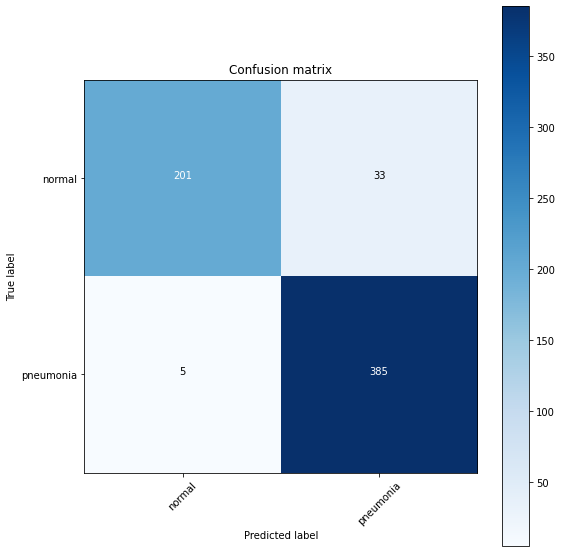

In [229]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# plot_confusion_matrix(val_cmt, ['normal','pneumonia'])
plt.figure(figsize=(8,8))
plot_confusion_matrix(test_cmt, ['normal','pneumonia'])